In [7]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
BATCH_SIZE = 32
TRAIN_REPEAT = 10

In [2]:
TCP_PORT = 13006

In [3]:
import numpy as np
import socket
import json

class tcp_env():
    def __init__(self, tcp_port):
        self.s=socket.socket(socket.AF_INET,socket.SOCK_STREAM)

        self.s.connect(('127.0.0.1',tcp_port))

        print( self.s.recv(1024).decode())

        data = { 'type' : 'init' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        self.state_dim = data_json["state_dim"]
        self.action_dim = data_json["action_dim"]
        self.DoF = data_json["DoF"]

        # s.send('exit')
        # s.close()        
        
    def  reset(self):
        data = { 'type' : 'reset' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        state = np.array( data_json["state"] )
        return state
    def step(self, action):
        
        data = { 'type' : 'step', 'action' : action.tolist() } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        str_recv = self.s.recv(1024).decode()
        
        data_json = json.loads( str_recv )
        
        state = np.array( data_json["state"] )
        r = data_json["reward"]
        d = data_json["done"]
        info = data_json["info"]
        
        return state, r, d, info
    def close_tcp(self):
        print(" close tcp ... ")
        data = { 'type' : 'close' } 

        str_json = json.dumps(data)
        self.s.send( str_json.encode() )
        self.s.close()        


In [4]:
env = tcp_env( tcp_port = TCP_PORT )

Welcome!


In [65]:
env.close_tcp()

 close tcp ... 


In [5]:
"""
View more on the tutorial page: https://morvanzhou.github.io/tutorials/
"""

import tensorflow as tf
import numpy as np
from tqdm import trange

# reproducible
np.random.seed(1)
tf.set_random_seed(1)

#####################  hyper parameters  ####################


MAX_EP_STEPS = 500
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound, env):
        self.env = env
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
                
        self.var = 3.0      
            
        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self.build_a_nn(self.S, scope='eval', trainable=True)
            a_ = self.build_a_nn(self.S_, scope='target', trainable=True)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self.build_c_nn(self.S, self.a, scope='eval', trainable=True)
            q_ = self.build_c_nn(self.S_, a_, scope='target', trainable=True)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [[tf.assign(at, (1-TAU)*at+TAU*ae), tf.assign(ct, (1-TAU)*ct+TAU*ce)]
            for at, ae, ct, ce in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=(self.R + GAMMA * q_), predictions=q)
        
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, name="adam-ink", var_list = self.ce_params)

        a_loss = - tf.reduce_mean(q) # maximize the q
        
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        tf.summary.FileWriter("logs/", self.sess.graph)
        
        self.saver = tf.train.Saver()
        
        if 1:
            self.sess.run(tf.global_variables_initializer())
        else:
            ckpt = tf.train.get_checkpoint_state("jaco-1joint/model.ckpt")  
            if ckpt and ckpt.model_checkpoint_path:  
                self.saver.restore(self.sess, ckpt.model_checkpoint_path)

    def choose_action(self, s):
        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
        
        a = np.clip(np.random.normal(a, self.var), -2, 2)
        
        return a

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})
        self.sess.run(self.atrain, {self.S: bs, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
    
        trans = np.hstack((s,a,[r],s_))
        
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1
        
        if self.pointer > MEMORY_CAPACITY:
            self.var *= 0.99995
            for _ in range(TRAIN_REPEAT):
                self.learn()
    def build_a_nn(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            s_norm = s# tf.layers.batch_normalization(s, training=self.is_training)
            l1 = tf.layers.dense(s_norm, 30, activation = tf.nn.tanh, name = 'l1', trainable = trainable)
            a = tf.layers.dense(l1, self.a_dim, activation = tf.nn.tanh, name = 'a', trainable = trainable)     
            return tf.multiply(a, self.a_bound, name = "scaled_a")  
    def build_c_nn(self, s, a, scope, trainable):
        # Critic Q-leaning
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable = trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable = trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable = trainable)
            
            s_norm = s# tf.layers.batch_normalization(s, training=self.is_training)
            a_norm = a# tf.layers.batch_normalization(a, training=self.is_training)
            
            linear_output = tf.matmul(s_norm, w1_s) + tf.matmul(a_norm, w1_a) + b1    
    
            net = tf.nn.tanh( linear_output )

            q = tf.layers.dense(net, 1, trainable = trainable)
            return q

    
###############################  training  ####################################

s_dim = env.state_dim
a_dim = env.action_dim
a_bound = 0.2

ddpg = DDPG(a_dim, s_dim, a_bound, env)
r_save = []

#### Decress the ddpg.var
Decress the ddpg.var at first

In [6]:
MAX_EPISODES = 200

for i in trange(MAX_EPISODES):
    s = env.reset()    
    
    act_save = []
    dis_save = []
    
    ep_reward = 0
    for j in range(MAX_EP_STEPS):

        # Add exploration noise
        a = ddpg.choose_action(s)
                
        s_, r, done, info = env.step(a)
        
        ddpg.store_transition(s, a, r, s_)

        s = s_
    
        ep_reward += r
        
        act_save.append( a )
        dis_save.append( info )
        
    r_save.append(ep_reward)

100%|██████████| 200/200 [48:14<00:00, 14.47s/it]


#### Test it
Test it without the adjustment of networks

In [8]:
MAX_EPISODES = 1

for i in trange(MAX_EPISODES):
    s = env.reset()    
    
    act_save = []
    dis_save = []
    qvel_save = []
    data_qvel_save = []
    
    for j in range(MAX_EP_STEPS):
        
        self = ddpg
        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
                
        s_, r, done, info = env.step(a)

        s = s_
    
        act_save.append( a )
        dis_save.append( info )
        
        qvel_save.append( s[:6] )
        data_qvel_save.append( s[6:12] )


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


In [9]:
qvel_save_2 = np.array( qvel_save )
qvel_save_2.shape

(500, 6)

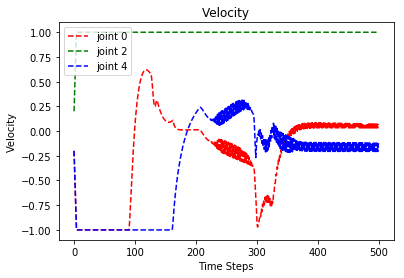

In [10]:

xypoints = qvel_save_2[:,0]
plt.plot(np.array(xypoints).reshape(-1), 'r--', label='joint 0')

xypoints = qvel_save_2[:,2]
plt.plot(np.array(xypoints).reshape(-1), 'g--', label='joint 2')

xypoints = qvel_save_2[:,4]
plt.plot(np.array(xypoints).reshape(-1), 'b--', label='joint 4')


plt.title('Velocity')
plt.xlabel('Time Steps')
plt.ylabel('Velocity')
plt.legend(loc='upper left')
plt.show()

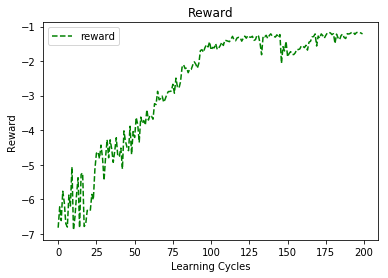

In [11]:
xypoints = r_save[:200]

plt.plot(np.array(xypoints[:]).reshape(-1), 'g--', label='reward')
plt.title('Reward')
plt.xlabel('Learning Cycles')
plt.ylabel('Reward')
plt.legend(loc='upper left')
plt.show()

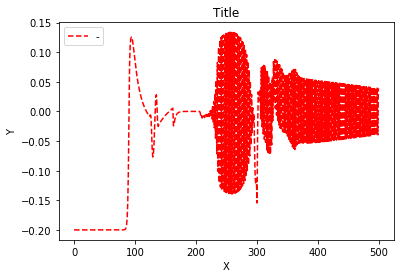

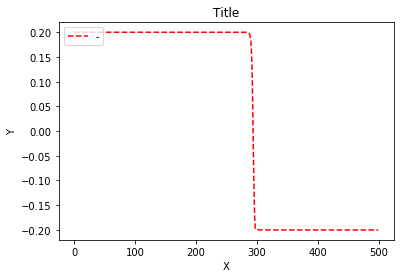

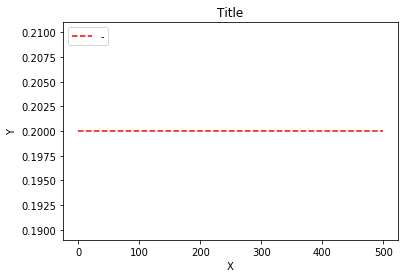

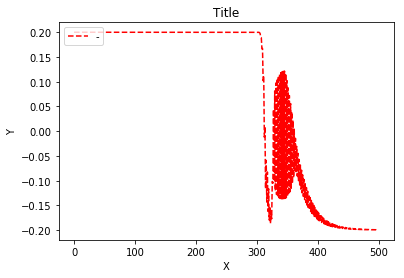

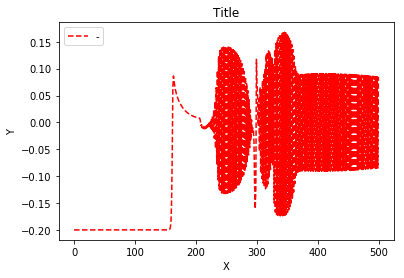

In [12]:
for i in [0,1,2,3,4]:
    xypoints = np.array( act_save )[:,i]

    plt.plot(np.array(xypoints).reshape(-1), 'r--', label='-')
    plt.title('Title')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')
    plt.show()

In [13]:
ddpg.var

0.03332324041433488

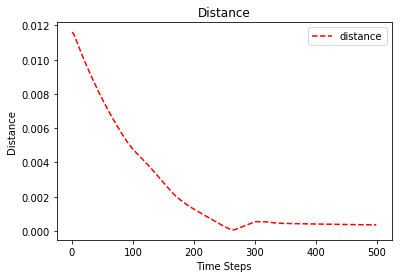

In [14]:
xypoints = dis_save

plt.plot(np.array(xypoints).reshape(-1), 'r--', label='distance')
plt.title('Distance')
plt.xlabel('Time Steps')
plt.ylabel('Distance')
plt.legend(loc='upper right')
plt.show()

In [15]:
min(dis_save)

[6.007883651755169e-05]

In [16]:
dis_save[-1]

[0.0003531393142654174]

## Save Network

In [52]:
ddpg.saver.save(ddpg.sess, 'ddpg-Client-v4-0.00001-3/model.ckpt')  

'ddpg-Client-v4-0.00001-3/model.ckpt'

### Results

        k_v = 0.00001
        r = -dis - k_v*np.lyinalg.norm( self.qvel )

#### (1)
        
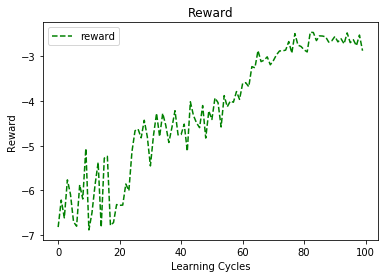
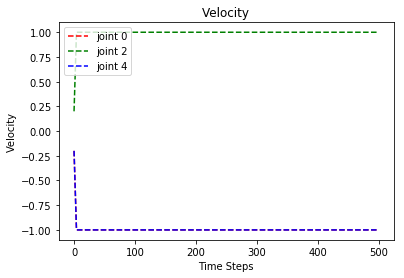
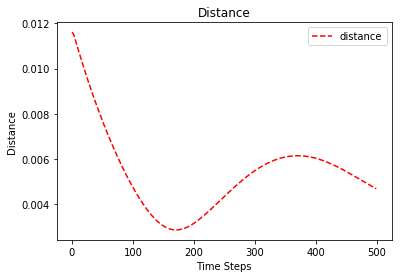

#### (2)

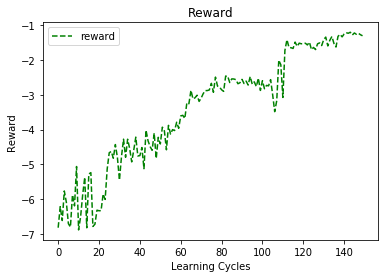
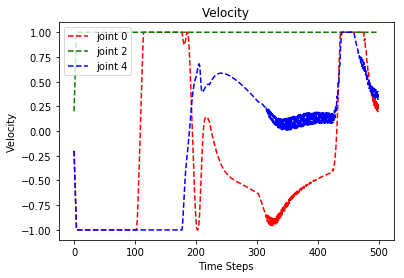
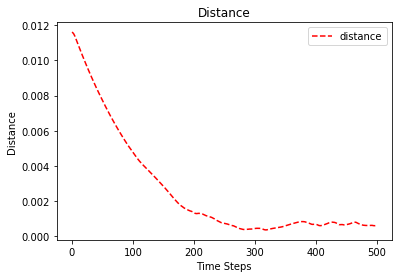


<img src="" />

---